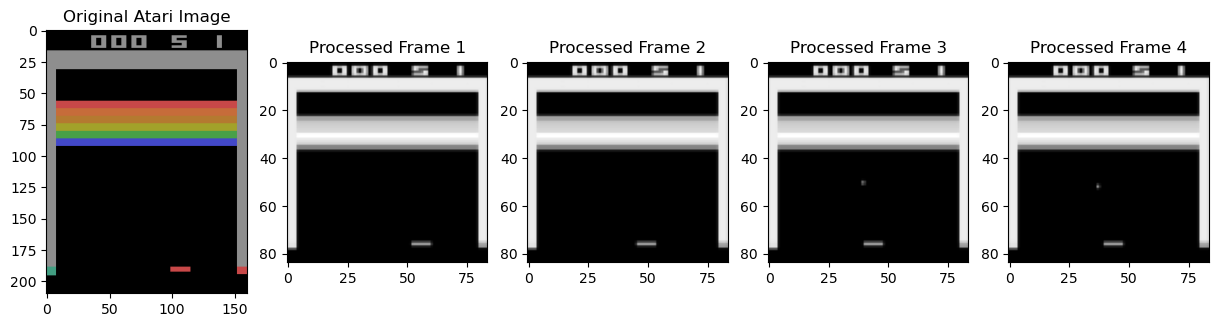

device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                  [-1, 512]       1,606,144
            Linear-5                    [-1, 4]           2,052
Total params: 1,686,180
Trainable params: 1,686,180
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.17
Params size (MB): 6.43
Estimated Total Size (MB): 6.71
----------------------------------------------------------------
Episode 1/500, Total Reward: 1.0, Epsilon: 0.995
Episode 2/500, Total Reward: 2.0, Epsilon: 0.990
Episode 3/500, Total Reward: 2.0, Epsilon: 0.985
Episode 4/500, Total Reward: 1.0, Epsilon: 0.980
Episode 5/500, Total 

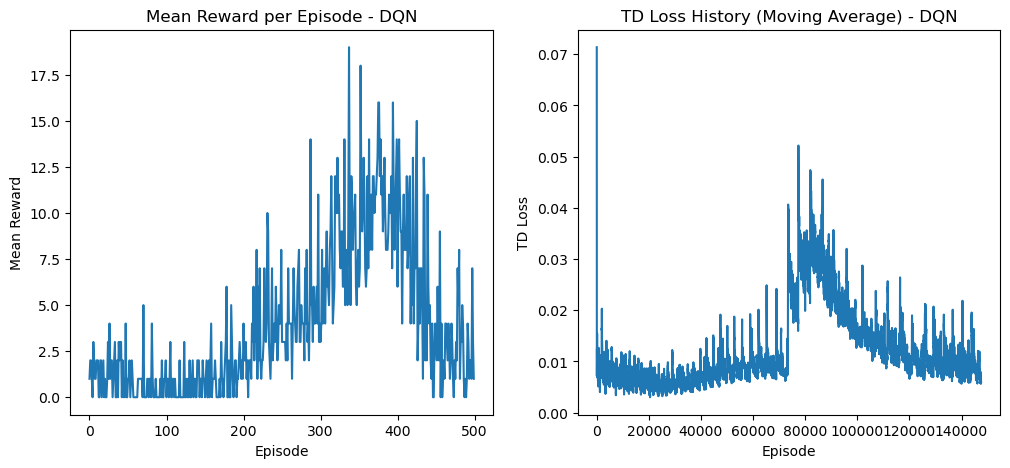

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray

# Hyperparameters
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
BATCH_SIZE = 32
MEMORY_SIZE = 100000
TARGET_UPDATE = 10
LR = 0.0001
NUM_EPISODES = 500
# Set up the environment
env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', obs_type="rgb")


# Preprocess the observation
def preprocess_observation(obs):
    gray = rgb2gray(obs)
    resized = resize(gray, (84, 84), mode='constant')
    return np.uint8(resized * 255)

# Display an Atari image and the actual observation after processing
obs, _ = env.reset()
processed_obs = preprocess_observation(obs)
state = np.stack([processed_obs] * 4, axis=0)

# Simulate some steps to get varied frames
for _ in range(3):
    next_obs, _, _, _, _ = env.step(env.action_space.sample())
    processed_next_obs = preprocess_observation(next_obs)
    state = np.append(state[1:], np.expand_dims(processed_next_obs, 0), axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.imshow(obs)
plt.title('Original Atari Image')

for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.imshow(state[i], cmap='gray')
    plt.title(f'Processed Frame {i + 1}')

plt.show()

# Neural network for the DQN
class DQN(nn.Module):
    def __init__(self, action_space):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, action_space)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Function to select an action
def select_action(state, epsilon, action_space):
    if random.random() < epsilon:
        return random.randrange(action_space)
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state)
            return q_values.max(1)[1].item()

# Update the target network
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

# Training function
def optimize_model():
    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = replay_buffer.sample(BATCH_SIZE)
    state_batch = torch.FloatTensor(np.array([b[0] for b in batch])).to(device)
    action_batch = torch.LongTensor(np.array([b[1] for b in batch])).to(device)
    reward_batch = torch.FloatTensor(np.array([b[2] for b in batch])).to(device)
    next_state_batch = torch.FloatTensor(np.array([b[3] for b in batch])).to(device)
    done_batch = torch.FloatTensor(np.array([b[4] for b in batch])).to(device)

    q_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
    next_q_values = target_net(next_state_batch).max(1)[0]
    expected_q_values = reward_batch + (GAMMA * next_q_values * (1 - done_batch))

    loss = criterion(q_values, expected_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()



# Initialize networks
action_space = env.action_space.n
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
policy_net = DQN(action_space).to(device)
target_net = DQN(action_space).to(device)
update_target(policy_net, target_net)

# Initialize optimizer and loss function
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
criterion = nn.MSELoss()

# Initialize replay buffer
replay_buffer = ReplayBuffer(MEMORY_SIZE)

# Initialize epsilon and lists for tracking metrics
epsilon = EPSILON_START
mean_rewards_dqn = []
losses_dqn = []

# Print the model summary
summary(policy_net, (4, 84, 84))

# Training loop
for episode in range(NUM_EPISODES):
    obs, _ = env.reset()
    state = preprocess_observation(obs)
    state = np.stack([state] * 4, axis=0)

    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon, action_space)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = preprocess_observation(next_obs)
        next_state = np.append(state[1:], np.expand_dims(next_state, 0), axis=0)

        replay_buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        loss = optimize_model()
        if loss:
            losses_dqn.append(loss)

        if done:
            mean_rewards_dqn.append(total_reward)
            epsilon = max(EPSILON_END, EPSILON_DECAY * epsilon)
            print(f"Episode {episode+1}/{NUM_EPISODES}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    if (episode + 1) % TARGET_UPDATE == 0:
        update_target(policy_net, target_net)

# Plotting the mean rewards and TD loss history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mean_rewards_dqn)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Mean Reward per Episode - DQN')

plt.subplot(1, 2, 2)
plt.plot(np.convolve(losses_dqn, np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('TD Loss')
plt.title('TD Loss History (Moving Average) - DQN')

plt.show()

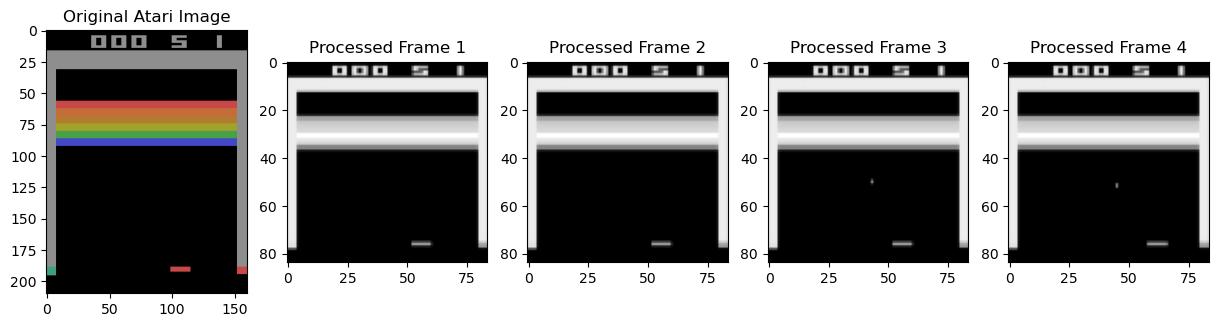

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 20, 20]           8,224
            Conv2d-2             [-1, 64, 9, 9]          32,832
            Conv2d-3             [-1, 64, 7, 7]          36,928
            Linear-4                  [-1, 512]       1,606,144
            Linear-5                    [-1, 1]             513
            Linear-6                    [-1, 4]           2,052
Total params: 1,686,693
Trainable params: 1,686,693
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.17
Params size (MB): 6.43
Estimated Total Size (MB): 6.71
----------------------------------------------------------------
Dueling DQN Episode 1/500, Total Reward: 0.0, Epsilon: 0.995
Dueling DQN Episode 2/500, Total Reward: 0.0, Epsilon: 0.990
Dueling DQN Episode 3/500, Total Reward: 1.0

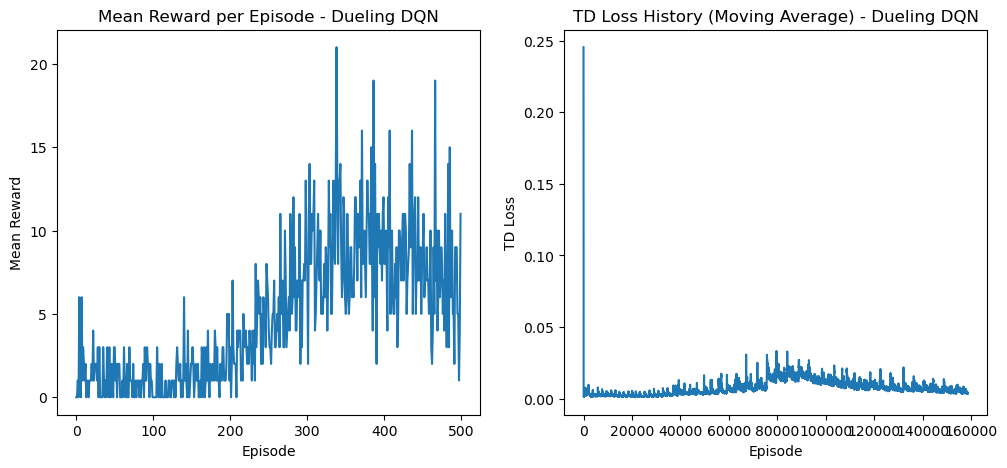

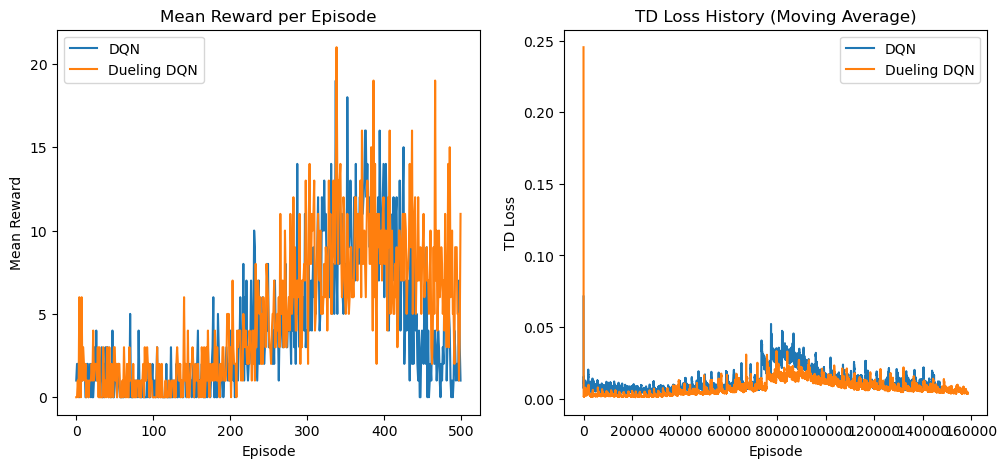

In [2]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray

# Hyperparameters
GAMMA = 0.99
EPSILON_START = 1.0
EPSILON_END = 0.1
EPSILON_DECAY = 0.995
BATCH_SIZE = 32
MEMORY_SIZE = 100000
TARGET_UPDATE = 10
LR = 0.0001
NUM_EPISODES = 500

# Set up the environment
env = gym.make("ALE/Breakout-v5", render_mode='rgb_array', obs_type="rgb")

# Preprocess the observation
def preprocess_observation(obs):
    gray = rgb2gray(obs)
    resized = resize(gray, (84, 84), mode='constant')
    return np.uint8(resized * 255)

# Display an Atari image and the actual observation after processing
obs, _ = env.reset()
processed_obs = preprocess_observation(obs)
state = np.stack([processed_obs] * 4, axis=0)

# Simulate some steps to get varied frames
for _ in range(3):
    next_obs, _, _, _, _ = env.step(env.action_space.sample())
    processed_next_obs = preprocess_observation(next_obs)
    state = np.append(state[1:], np.expand_dims(processed_next_obs, 0), axis=0)

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.imshow(obs)
plt.title('Original Atari Image')

for i in range(4):
    plt.subplot(1, 5, i + 2)
    plt.imshow(state[i], cmap='gray')
    plt.title(f'Processed Frame {i + 1}')

plt.show()

# Neural network for the DQN
class DQN(nn.Module):
    def __init__(self, action_space):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, action_space)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Neural network for the Dueling DQN
class DuelingDQN(nn.Module):
    def __init__(self, action_space):
        super(DuelingDQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.value_stream = nn.Linear(512, 1)
        self.advantage_stream = nn.Linear(512, action_space)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))
        return q_values

# Replay buffer to store experiences
class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# Function to select an action
def select_action(state, epsilon, action_space):
    if random.random() < epsilon:
        return random.randrange(action_space)
    else:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state)
            return q_values.max(1)[1].item()

# Update the target network
def update_target(policy_net, target_net):
    target_net.load_state_dict(policy_net.state_dict())

# Training function
def optimize_model():
    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = replay_buffer.sample(BATCH_SIZE)
    state_batch = torch.FloatTensor(np.array([b[0] for b in batch])).to(device)
    action_batch = torch.LongTensor(np.array([b[1] for b in batch])).to(device)
    reward_batch = torch.FloatTensor(np.array([b[2] for b in batch])).to(device)
    next_state_batch = torch.FloatTensor(np.array([b[3] for b in batch])).to(device)
    done_batch = torch.FloatTensor(np.array([b[4] for b in batch])).to(device)

    q_values = policy_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
    next_q_values = target_net(next_state_batch).max(1)[0]
    expected_q_values = reward_batch + (GAMMA * next_q_values * (1 - done_batch))

    loss = criterion(q_values, expected_q_values.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# Initialize networks for DQN
# action_space = env.action_space.n
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"device: {device}")
# policy_net = DQN(action_space).to(device)
# target_net = DQN(action_space).to(device)
# update_target(policy_net, target_net)

# # Initialize optimizer and loss function for DQN
# optimizer = optim.Adam(policy_net.parameters(), lr=LR)
# criterion = nn.MSELoss()

# # Initialize replay buffer for DQN
# replay_buffer = ReplayBuffer(MEMORY_SIZE)

# # Initialize epsilon and lists for tracking metrics for DQN
# epsilon = EPSILON_START
# mean_rewards_dqn = []
# losses_dqn = []

# # Training loop for DQN
# for episode in range(NUM_EPISODES):
#     obs, _ = env.reset()
#     state = preprocess_observation(obs)
#     state = np.stack([state] * 4, axis=0)

#     total_reward = 0
#     done = False
#     while not done:
#         action = select_action(state, epsilon, action_space)
#         next_obs, reward, terminated, truncated, _ = env.step(action)
#         done = terminated or truncated
#         next_state = preprocess_observation(next_obs)
#         next_state = np.append(state[1:], np.expand_dims(next_state, 0), axis=0)

#         replay_buffer.add((state, action, reward, next_state, done))
#         state = next_state
#         total_reward += reward

#         loss = optimize_model()
#         if loss:
#             losses_dqn.append(loss)

#         if done:
#             mean_rewards_dqn.append(total_reward)
#             epsilon = max(EPSILON_END, EPSILON_DECAY * epsilon)
#             print(f"DQN Episode {episode+1}/{NUM_EPISODES}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

#     if (episode + 1) % TARGET_UPDATE == 0:
#         update_target(policy_net, target_net)

# Initialize networks for Dueling DQN
policy_net = DuelingDQN(action_space).to(device)
target_net = DuelingDQN(action_space).to(device)
update_target(policy_net, target_net)

# Initialize optimizer and loss function for Dueling DQN
optimizer = optim.Adam(policy_net.parameters(), lr=LR)
criterion = nn.MSELoss()

# Initialize replay buffer for Dueling DQN
replay_buffer = ReplayBuffer(MEMORY_SIZE)

# Initialize epsilon and lists for tracking metrics for Dueling DQN
epsilon = EPSILON_START
mean_rewards_dueling_dqn = []
losses_dueling_dqn = []

# Print the model summary
summary(policy_net, (4, 84, 84))

# Training loop for Dueling DQN
for episode in range(NUM_EPISODES):
    obs, _ = env.reset()
    state = preprocess_observation(obs)
    state = np.stack([state] * 4, axis=0)

    total_reward = 0
    done = False
    while not done:
        action = select_action(state, epsilon, action_space)
        next_obs, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        next_state = preprocess_observation(next_obs)
        next_state = np.append(state[1:], np.expand_dims(next_state, 0), axis=0)

        replay_buffer.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        loss = optimize_model()
        if loss:
            losses_dueling_dqn.append(loss)

        if done:
            mean_rewards_dueling_dqn.append(total_reward)
            epsilon = max(EPSILON_END, EPSILON_DECAY * epsilon)
            print(f"Dueling DQN Episode {episode+1}/{NUM_EPISODES}, Total Reward: {total_reward}, Epsilon: {epsilon:.3f}")

    if (episode + 1) % TARGET_UPDATE == 0:
        update_target(policy_net, target_net)



# Plotting the mean rewards and TD loss history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mean_rewards_dueling_dqn)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Mean Reward per Episode - Dueling DQN')

plt.subplot(1, 2, 2)
plt.plot(np.convolve(losses_dueling_dqn, np.ones(100)/100, mode='valid'))
plt.xlabel('Episode')
plt.ylabel('TD Loss')
plt.title('TD Loss History (Moving Average) - Dueling DQN')

plt.show()


# Plotting the mean rewards and TD loss history for both DQN and Dueling DQN
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(mean_rewards_dqn, label='DQN')
plt.plot(mean_rewards_dueling_dqn, label='Dueling DQN')
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Mean Reward per Episode')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(np.convolve(losses_dqn, np.ones(100)/100, mode='valid'), label='DQN')
plt.plot(np.convolve(losses_dueling_dqn, np.ones(100)/100, mode='valid'), label='Dueling DQN')
plt.xlabel('Episode')
plt.ylabel('TD Loss')
plt.title('TD Loss History (Moving Average)')
plt.legend()

plt.show()
